In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit
from PIL import Image

import scipy.ndimage as nd

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects

%matplotlib inline

%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\4D_CT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load .npy files

names = [
    # "hourglassV3_13_55",
    "limestoneV3_17_55_12favg",
]



crossections = { }

identifiers = [
    "gt",
    # "gt",
    # "Rec_0_1_sirt",
    # "Rec_0_1_sirt",
    # "Rec_0_1_sirt_enhanced_800512512",
    # "Rec_0_1_fdk",
    "Rec_0_1_fdk_enhanced_700428728",
    "Rec_0_1_sirt_enhanced_700428728",
    "Rec_0_1_fdk_enhanced_700428728_final",

]
keys = [
    # "hgt",
    "sgt",
    # "h26",
    # "s26",
    # "h26_enhanced",
    "s26_enhanced",
    "s26_sirt_enhanced",
    "s26_liger_enhanced"
]

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers, keys)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
        root = r"C:\Users\Bruker\Documents\GANPICCS"
    elif "limestone" in names[0]:
        x1, x2 = 572, 828  # 672, 928
        y1, y2 = 300, 556  # 384, 640
        z1, z2 = 600, 856  # 384, 640
        root = r"C:\Users\Bruker\Documents\Sandstone"
    else:
        x1, x2 = 672, 928
        y1, y2 = 384, 640
        z1, z2 = 384, 640
        root = r"C:\Users\Bruker\Documents\4DCT"

    load_name = f"{names[0]}_{identifiers[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
    load_path = os.path.join(root, load_name)
    crossections[key]= np.squeeze(np.load(load_path))

SSIM 0: 0.91, 0.74, 0.81
SSIM 1: 0.86, 0.70, 0.82
SSIM 2: 0.60, 0.39, 0.61


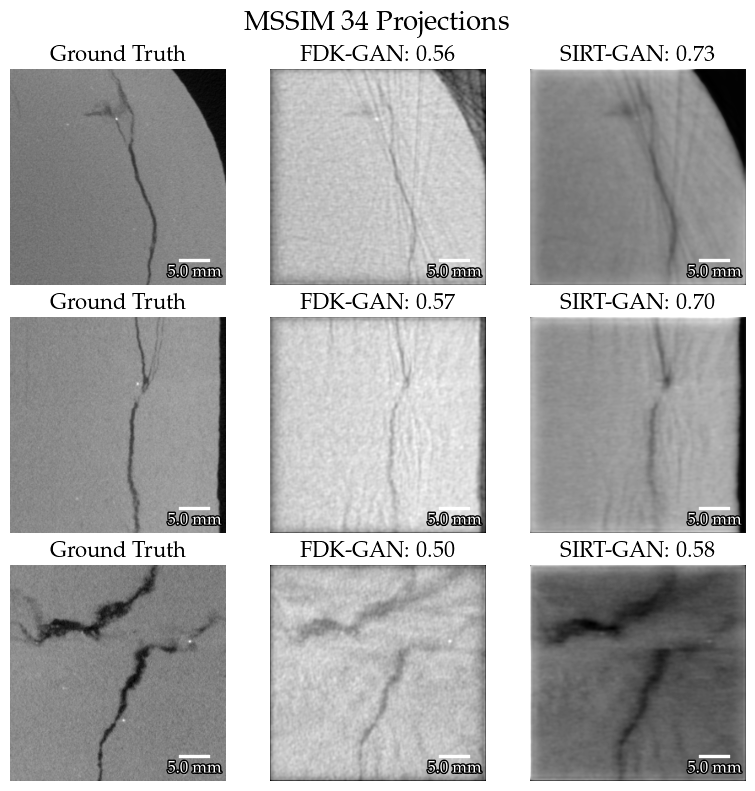

In [7]:
all_slices = []
all_labels = []

slice_norm = lambda x, ref : x* (np.max(ref) - np.min(ref)) + np.min(ref)


slice_indexer_x = lambda x, h: x[h]
slice_indexer_y = lambda x, h: x[:,h]
slice_indexer_z = lambda x, h: x[:,:,h]

slice_indexer = [slice_indexer_x, slice_indexer_y, slice_indexer_z]
hs = [128, 100, 160]
key = str(17) #Sandstone not re-reconstructed at this point. Satisfied with number of projections.

for i, si in enumerate(slice_indexer):

    slgt = si(crossections["sgt"], hs[i])
    # slin = si(crossections["s26"], hs[i])
    slout = slice_norm(si(crossections["s26"+"_enhanced"], hs[i]), crossections["sgt"])
    slit = slice_norm(si(crossections["s26"+"_sirt_enhanced"], hs[i]), crossections["sgt"])
    sliger = slice_norm(si(crossections["s26"+"_liger_enhanced"], hs[i]), crossections["sgt"])

    all_slices.extend([slgt, slout, slit,])# sliger])

    k=  11
    

    mssout, _ = utils.calc_mssim(slgt, slout, k=k)    
    mssit, _ = utils.calc_mssim(slgt, slit, k=k)
    mssliger, _ = utils.calc_mssim(slgt, sliger, k=k)

    all_labels.extend([f"Ground Truth", f"FDK-GAN: {mssout:.2f}", f"SIRT-GAN: {mssit:.2f}",]) # f"LIGER-GAN: {mssliger:.2f}"])

    ssit, _ = utils.evaluate_recs(  slgt, slit, normalise=True)  
    ssout, _ = utils.evaluate_recs( slgt, slout, normalise=True)
    ssiger, _ = utils.evaluate_recs( slgt, sliger, normalise=True)

    print(f"SSIM {i}: {ssit:.2f}, {ssout:.2f}, {ssiger:.2f}")

scale_kwargs = {
    "size": 5 / (0.2 * 930) * 1350,
    "label": f"5.0 mm",
    "color": "white",
    "loc": 4,
    "frameon": False,
    "size_vertical": 3,
    "label_top": False,
    # "font_properties": {"size": 16}
}
plot_slice_grid(
    all_slices,
    all_labels,
    suptitle=f"MSSIM {str(int(key)+17)} Projections",
    folder="GANPICCS",
    savefile="GANPICCS_sandstone",
    savefig=True,
    bar = True,
    scalebar_kwargs=scale_kwargs,
    fs = (2,2),
    ns = (3,3)    
)

In [20]:
def GANPICCS_table(attr,name, rows, cols=4, int_lenght=1):

    tab = []
    #Initializing tabular env
    cs = ""
    for i in range(cols):
        cs += "c "
    tab.append("\\begin{tabular}{%s}"%cs)

    #creating header
    tab.append("\\hline")
    tab.append("\\multicolumn{%i}{c}{\\textbf{%s}} \\\\"%(cols, name))

    header_titles = "\\textbf{Projections} & \\textbf{SSIM} &\\textbf{MSSIM} & \\textbf{PSNR}  \\\\" #%(cols-1)
    tab.append(header_titles)
    # header = ""
    # for i in range(len(exposures)):
    #     header += "& \\textbf{\\num{%s}%s} "%(exposures[i][:-1], exposures[i][-1])
    # header += "\\\\"
    # tab.append(header)
    tab.append("\\hline")

    for j, (key,id) in enumerate(rows.items()):
        row = "\\textbf{%s} "%key
        for i, (k, v) in enumerate(attr.items()):
            if int_lenght == 1:
                row += "& \\num{%.3f}"%attr[k][id]
            elif int_lenght >=3:
                row += "& \\num{%.0f}"%attr[k][id]
            else:
                row += "& \\num{%.2f}"%attr[k][id]
        row += "\\\\"
        tab.append(row)

    #Finishing tabular env
    tab.append("\\hline")
    tab.append("\\end{tabular}")
    return tab


def evaluate(x,y, normalise=False):

    # Normalises between 0 and 1
    if normalise:
        x = (x- np.min(x)) / (np.max(x)-np.min(x))
        y = (y- np.min(y)) / (np.max(y)-np.min(y))

    ssim = utils.calc_ssim(x, y)
    psnr = utils.calc_psnr(x, y)
    return ssim, psnr

In [32]:
ssims = {}
psnrs = {}
mssims = {}

x1, x2 = 0, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

for k, v in crossections.items():
    if k == "sgt":
        continue
    if "liger" in k:
        continue

    ss, ps = evaluate(crossections["sgt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2], normalise=True)
    ssims[k] = ss #utils.calc_ssim(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])
    psnrs[k] = ps #utils.calc_psnr(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])

    mssim_sum = 0
    for i in range(x2-x1):
        mean1 = np.mean((crossections["sgt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2] - np.min(crossections["sgt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2]))/( np.max(crossections["sgt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2]) - np.min(crossections["sgt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2])))
        mean2 = np.mean(v[x1 + i:x1+ 1 +i, y1:y2, z1:z2])
        val, _ = utils.calc_mssim(crossections["sgt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2], v[x1 + i:x1+ 1 +i, y1:y2, z1:z2] )
        mssim_sum += val
    mssims[k] = mssim_sum/(x2-x1)  #utils.calc_mssim(crossections["gt"][h, y1:y2, z1:z2], v[h, y1:y2, z1:z2] ) #mssim_sum / len(v) #

print(ssims)
print(psnrs)
print(mssims)

{'s26_enhanced': 0.5800207956227454, 's26_sirt_enhanced': 0.5368196449107268}
{'s26_enhanced': 10.834024300401964, 's26_sirt_enhanced': 11.448661501057709}
{'s26_enhanced': 0.5341027362737805, 's26_sirt_enhanced': 0.6300205817678943}


In [26]:
tab = GANPICCS_table({"ssim":ssims, "mssim":mssims, "psnr":psnrs},"Prior Knowledge 34 Projections", {"FDK-GAN":"s26_enhanced", "SIRT-GAN": "s26_sirt_enhanced"}, cols=4, int_lenght=2)
for t in tab:
    print(t)

\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{Prior Knowledge 34 Projections}} \\
\textbf{Projections} & \textbf{SSIM} &\textbf{MSSIM} & \textbf{PSNR}  \\
\hline
\textbf{FDK-GAN} & \num{0.58}& \num{0.53}& \num{10.83}\\
\textbf{SIRT-GAN} & \num{0.54}& \num{0.63}& \num{11.45}\\
\hline
\end{tabular}
